We need two things for generating coexpression proxies for a new species, single cell data and an orthology relationship. This template helps generate a coexpression network, but the orthology relationship will need to come from another existing tool. 

In [2]:
import pandas as pd
import scanpy as sc
import h5py
import CococoNet_reader
import numpy as np
import anndata


import Go_annotations
import seaborn as sns
import matplotlib.pyplot as plt
sc.settings.verbosity = 3  
sc.set_figure_params(facecolor = 'white', figsize = (10,8))

First, read in your single cell data below, we will use it to build a coexpression network. 

In [3]:
single_cell_arabidopsis_root = sc.read_h5ad('/data/passala/Collaborator_Data/Marchatia_data/Single_cell_data/marcatia_convert_step1.h5ad')

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [18]:
single_cell_arabidopsis_root.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,RNA_snn_res.0.6,seurat_clusters,RNA_snn_res.0.5,n_genes,leiden
S0_AAACCCAAGAAAGCGA,0,14303.0,2983,0.0,0,0,0,2607,332
S0_AAACCCAAGACGTCGA,0,7213.0,2826,0.0,7,9,9,2669,137
S0_AAACCCAAGAGTCAAT,0,10556.0,2956,0.0,9,8,8,2780,84
S0_AAACCCAAGATACATG,0,7988.0,2496,0.0,0,0,0,2367,591
S0_AAACCCAAGCCTAGGA,0,1947.0,1016,0.0,0,0,0,1076,297
...,...,...,...,...,...,...,...,...,...
S5_TTTGGTTGTGGCTACC,5,1109.0,530,0.0,8,7,7,638,153
S5_TTTGGTTTCGCAATTG,5,1049.0,561,0.0,2,2,2,671,650
S5_TTTGGTTTCTCCTGAC,5,2051.0,877,0.0,2,2,2,927,356
S5_TTTGTTGCAAATCCCA,5,906.0,527,0.0,2,2,2,653,800


Here, we do basic filtering. This dataset is older, so higher thresholds are likely more appropriate for your data. 

In [7]:
sc.pp.filter_cells(single_cell_arabidopsis_root, min_genes=200)
sc.pp.filter_genes(single_cell_arabidopsis_root, min_cells=3)

filtered out 222 genes that are detected in less than 3 cells


Here, we identify and visualize our data to pick highly variable genes. Refer to the Scanpy tutorial for more info on this. 

In [8]:
sc.pp.highly_variable_genes(single_cell_arabidopsis_root, min_mean=0.125, max_mean=4, min_disp=0.5)


extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


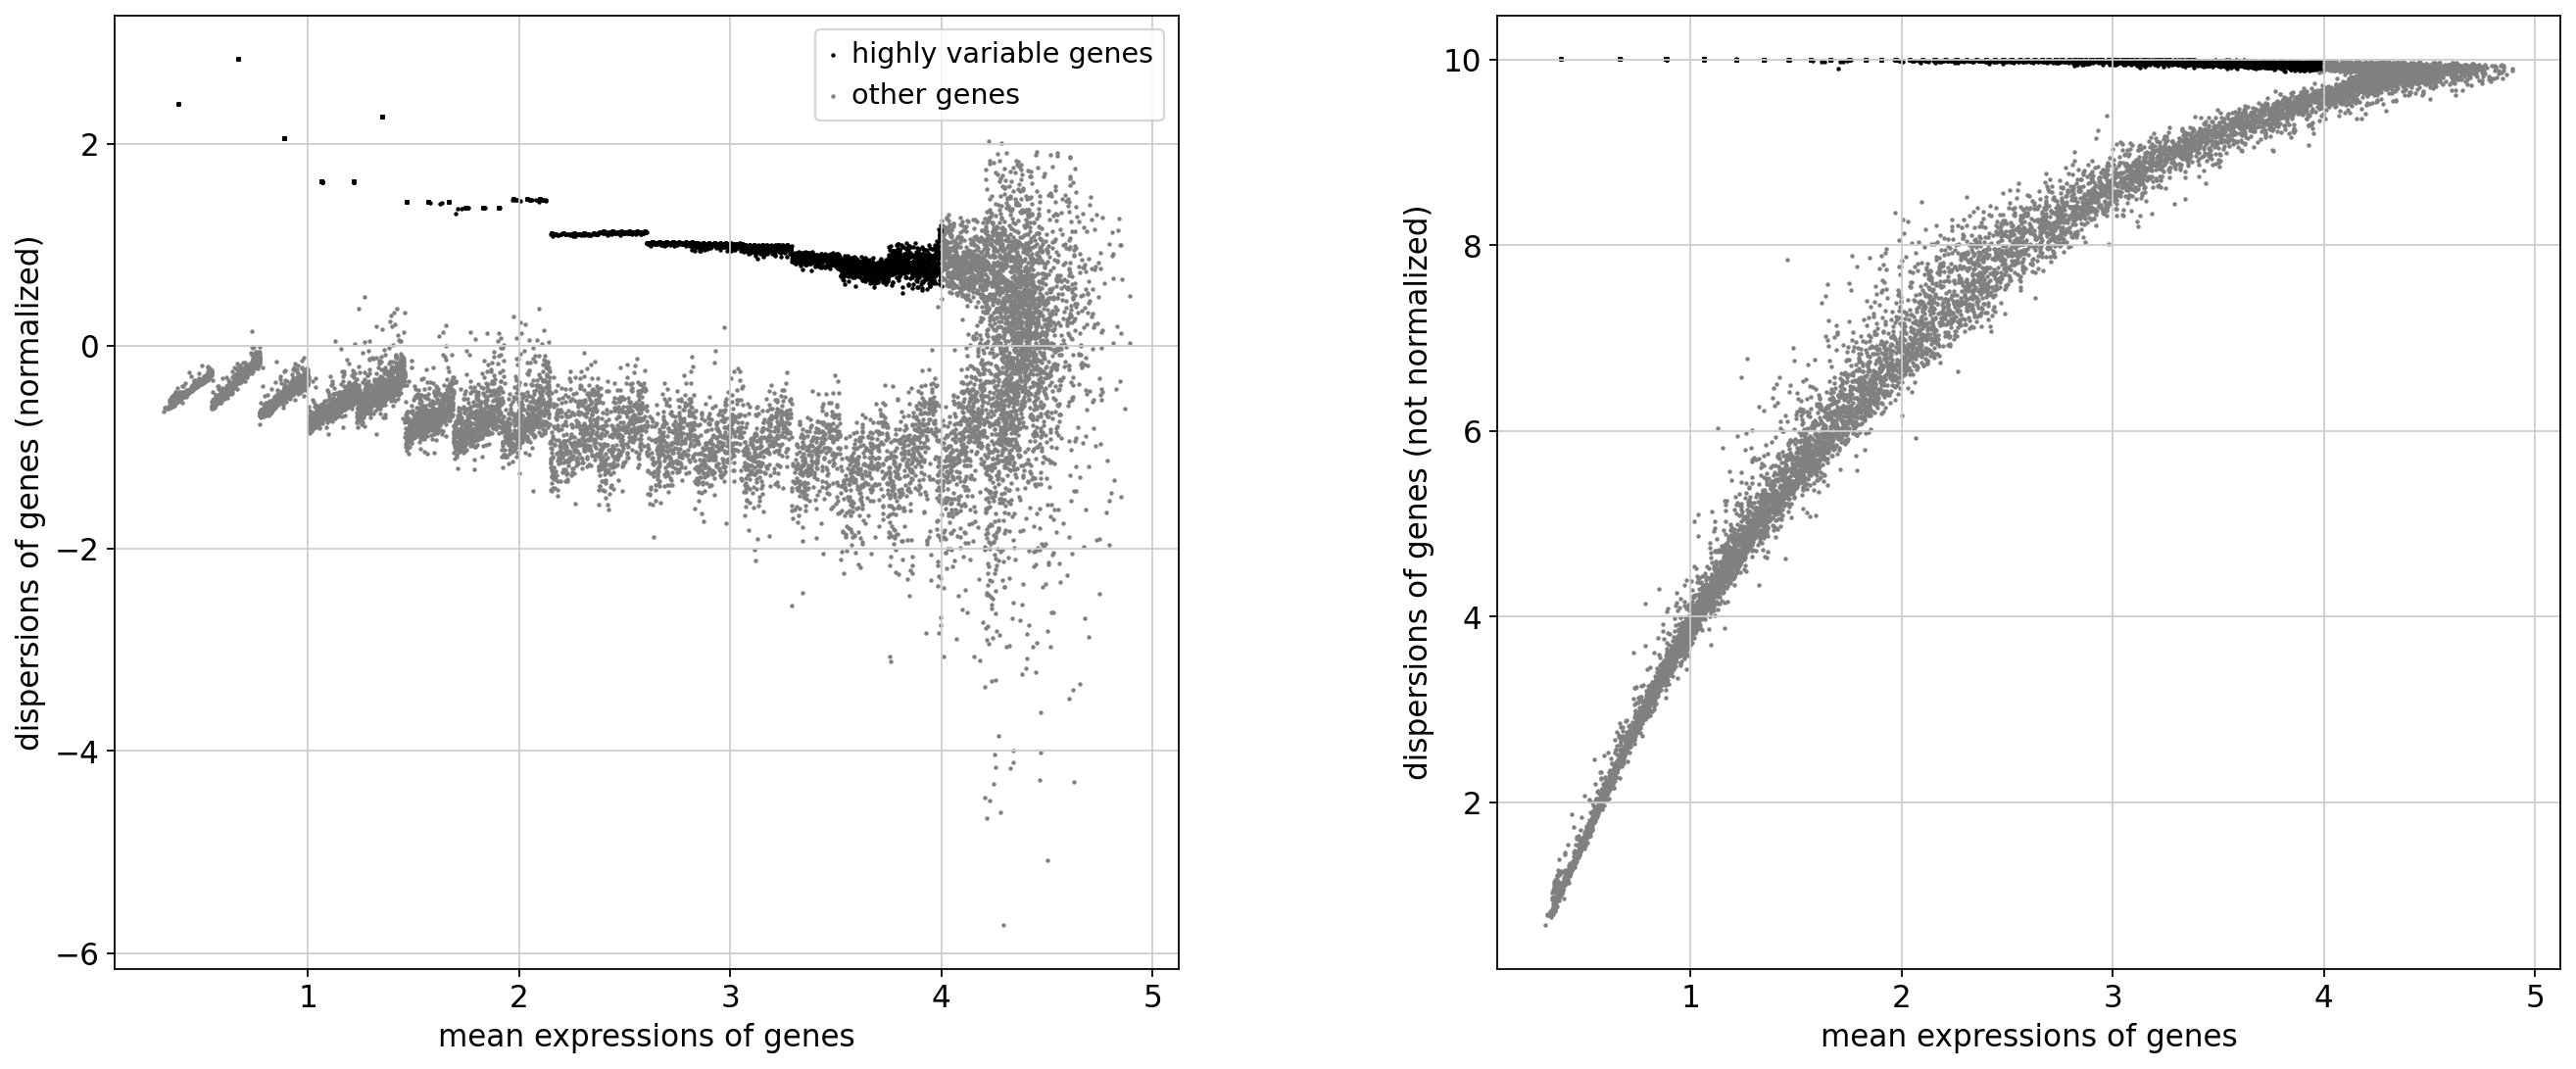

In [9]:
sc.pl.highly_variable_genes(single_cell_arabidopsis_root)


Next, we do standard preprocessing for clustering.

In [10]:
sc.tl.pca(single_cell_arabidopsis_root, svd_solver='arpack', random_state=303)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:30)


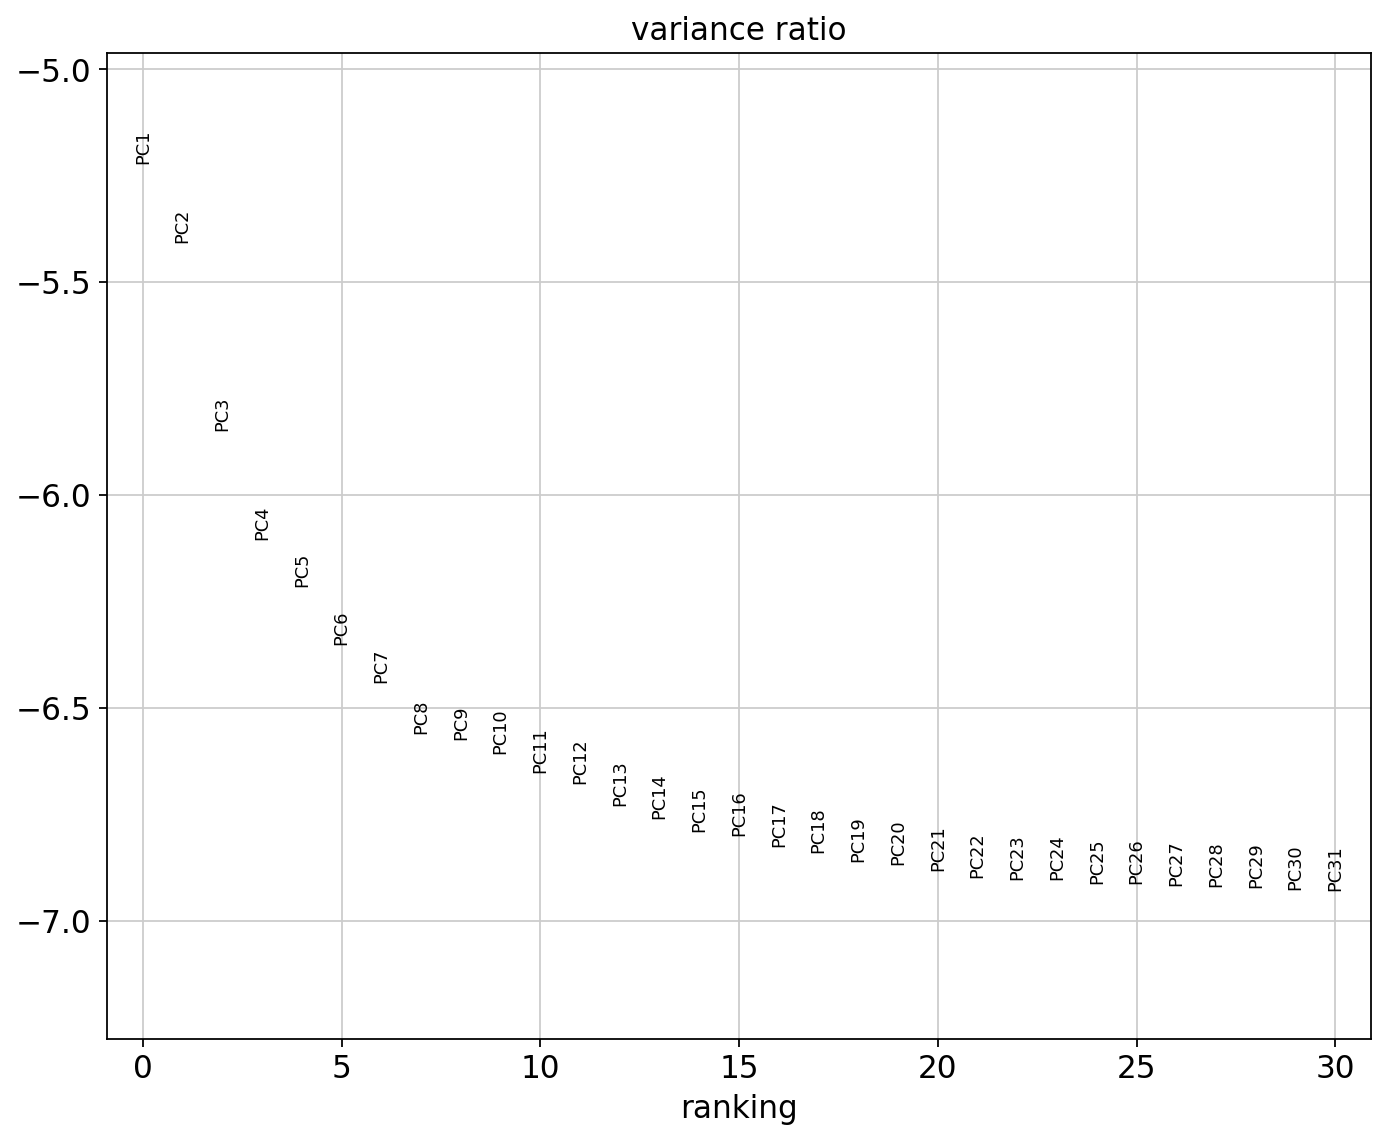

In [11]:
sc.pl.pca_variance_ratio(single_cell_arabidopsis_root, log=True)


In [25]:
sc.pp.neighbors(single_cell_arabidopsis_root, n_neighbors=30, n_pcs=50)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


In [26]:
sc.tl.umap(single_cell_arabidopsis_root, random_state = 233)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:49)


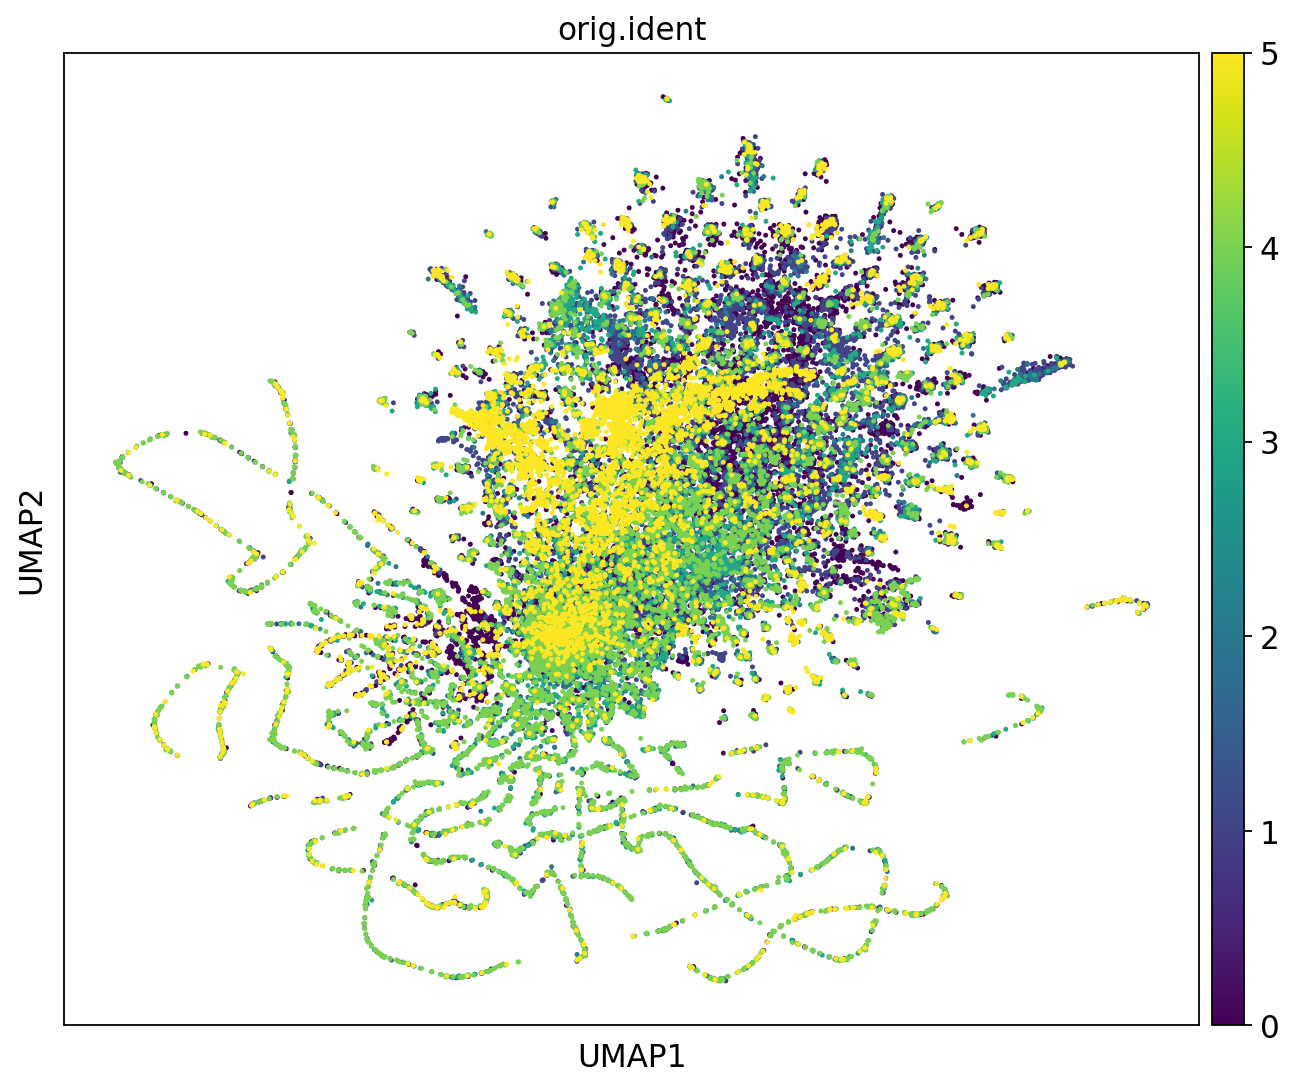

In [27]:
sc.pl.umap(single_cell_arabidopsis_root, color = 'orig.ident', s = 20)

Here, we majorly diverge from a standard clustering pipeline. We want to pick a resolution such that we have several hundred clusters, and that most clusters have low double digit numbers of cells. This resolution will probably be ridiculously high, in the 50-200 range. 

In [16]:
sc.tl.leiden(single_cell_arabidopsis_root,resolution = 50, random_state = 203)

running Leiden clustering
    finished: found 1159 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)


Check how many cells are in biggest and smallest clusters

In [17]:
single_cell_arabidopsis_root.obs['leiden'].value_counts().head(20)

0     196
1     169
2     159
3     136
4     133
5     133
6     131
7     129
8     127
9     127
10    127
11    126
12    125
13    124
14    122
15    122
16    121
18    119
19    119
17    119
Name: leiden, dtype: int64

In [ ]:
single_cell_arabidopsis_root.obs['leiden'].value_counts().tail(20)

In [ ]:
single_cell_arabidopsis_root

Now, we are going to psuedobulk our samples, averaging expression within each tiny cluster

In [ ]:
psuedobulk_df = pd.DataFrame(index = single_cell_arabidopsis_root.var_names)## Make a base dataframe index we will add stuff on to later
all_samples = list(single_cell_arabidopsis_root.obs.leiden.unique())  ## get list of clusters to loop through
psuedobulk_df

In [ ]:
len(all_samples)

Below we actually do the psuedobulk.

In [ ]:
for batch_type in all_samples:

    ## Read in the Names so our code is easy to understand
    current_cluster = batch_type

    ## Calculate the Psuedobulked mean
    cells_matching_batch_and_cluster = single_cell_arabidopsis_root[single_cell_arabidopsis_root.obs['leiden'] == current_cluster ]
    mean_of_genes = cells_matching_batch_and_cluster.X.mean(axis = 0).tolist()


    name_of_combo = current_cluster
    psuedobulk_df[name_of_combo] = mean_of_genes

In [ ]:
psuedobulk_df

In [ ]:
exp_data = psuedobulk_df

Next, we efficiently generate the spearman coexpression matrix, should be faster than .corr

In [ ]:
import numpy as np
import scipy.stats as sci

rank_test_py_exp = sci.rankdata(exp_data, method = 'average', axis = 1)                #Row ranks
rank_test_py_exp = rank_test_py_exp - rank_test_py_exp.mean(axis = 1)[1]               #Center each gene, subtract mean rank
rank_test_py_exp_2 = np.square(rank_test_py_exp)                                       #Square
rank_test_py_exp = rank_test_py_exp /np.sqrt(rank_test_py_exp_2.sum(axis = 1))[:,None] #divide by sqrt(rowSums)
cr_python = np.dot(rank_test_py_exp, rank_test_py_exp.T)                               # Get correlations

In [ ]:
cr_python

Put the results in a labeled dataframe, and this is your coexpression network!

In [ ]:
corr_results = pd.DataFrame(columns = psuedobulk_df.index, index = psuedobulk_df.index, data = cr_python)
corr_results

Next, we need an orthology mapping of our data. It should be all many to many gene pairs, formatted into 5 columns. 


Species_1-OrthoDB Gene ID , Species_2-OrthoDB Gene ID, Orthogroup, Species_1 Gene ID Used in your single cell data,Species_2 Gene ID Used in your single cell data

Next, use the two following functions to generate the list, dropping in your data and the generated coexpression network/networks in the first function

In [ ]:
def Calculate_Score_list_for_thresholding(orthology_map,species_1_coexpression_network,species_2_coexpression_network):
    import pandas as pd
    #Get Species Names in Common form 


    cross_species_n_m_genes = pd.read_csv(orthology_map)
    orig_column_common_name_1 = common_name_1 + ' Symbol'
    orig_column_common_name_2 = common_name_2 + ' Symbol'
    cross_species_n_m_genes = cross_species_n_m_genes.rename(columns = {orig_column_common_name_1:common_name_1,orig_column_common_name_2:common_name_2})
    ### Get one to ones
    cross_species_map_one_to_one = cross_species_n_m_genes.drop_duplicates(subset=common_name_1, keep= False,)
    cross_species_map_one_to_one = cross_species_map_one_to_one.drop_duplicates(subset= common_name_2, keep= False)

    ## Convert to Dictionary
    dictionary_mapper_one_to_two = cross_species_map_one_to_one.set_index(common_name_1).to_dict()[common_name_2]
    dictionary_mapper_dos_to_uno = cross_species_map_one_to_one.set_index(common_name_2).to_dict()[common_name_1]

    ## Read In Cococonets 
    coconet_species_one = species_1_coexpression_network
    coconet_species_two = species_2_coexpression_network

    cross_species_n_m_genes['Group ID'] = 'Unassigned'


    ## Assign Genes to Groups
    id_indexer = 0
    for gene_pair in cross_species_n_m_genes.iterrows():
        
        if gene_pair[1]['Group ID'] == 'Unassigned':
            current_species_1_gene = gene_pair[1][common_name_1]
            current_species_2_gene = gene_pair[1][common_name_2]
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_1] == current_species_1_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_2] == current_species_2_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer

            all_labeled_groups = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == id_indexer]

            all_labeled_groups_species_1_genes = all_labeled_groups[common_name_1].to_list()
            all_labeled_groups_species_2_genes = all_labeled_groups[common_name_2].to_list()

            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_1].isin(all_labeled_groups_species_1_genes)] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_2].isin(all_labeled_groups_species_2_genes)] = id_indexer

            id_indexer += 1



    #Identify Pairs for evaluation
    all_pairs_to_evaluate_for_functional_conservation = pd.DataFrame(columns = [common_name_1,common_name_2,'Group Number'])
    for group_number in list(set(cross_species_n_m_genes['Group ID'].to_list())):
        current_gene_map = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == group_number]
        list_of_species_1_genes_in_group = list(set(current_gene_map[common_name_1].to_list()))
        list_of_species_2_genes_in_group = list(set(current_gene_map[common_name_2].to_list()))
        all_combo_list_current_genes = itertools.product(list_of_species_1_genes_in_group,list_of_species_2_genes_in_group)
        all_combo_list_current_genes = list(map(list,all_combo_list_current_genes))
        current_list_of_pairs = pd.DataFrame(all_combo_list_current_genes,columns = [common_name_1,common_name_2])
        current_list_of_pairs['Group Number'] = group_number
        all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)



    all_pairs_to_evaluate_for_functional_conservation['Species 1 Score'] = np.nan
    all_pairs_to_evaluate_for_functional_conservation['Species 2 Score'] = np.nan


    ## Trim cococonets to match


    trimmed_species_1_cococonet = coconet_species_one[coconet_species_one.columns.intersection(cross_species_n_m_genes[common_name_1].to_list())]
    trimmed_species_1_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.index.isin(cross_species_n_m_genes[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = double_species_1_trimmed_cococonet.replace(1,0)

    trimmed_species_2_cococonet = coconet_species_two[coconet_species_two.columns.intersection(cross_species_n_m_genes[common_name_2].to_list())]
    trimmed_species_2_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.index.isin(cross_species_n_m_genes[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = double_species_2_trimmed_cococonet.replace(1,0)


    ## Rank
    species_1_cococonet_ranked = trimmed_species_1_cococonet.rank()
    species_2_cococonet_ranked = trimmed_species_2_cococonet.rank()

    #Do top 10 Genes
    top_10_species_1_genes = np.array(
        [double_species_1_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_1_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_1_genes_dataframe = pd.DataFrame(
        data=top_10_species_1_genes,
        index=double_species_1_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )

    #Convert 
    top_10_species_1_genes_as_species_2 = top_10_species_1_genes_dataframe.replace(to_replace=dictionary_mapper_one_to_two)

    # Get genes for checking 
    have_species_1_pairs = all_pairs_to_evaluate_for_functional_conservation.loc[all_pairs_to_evaluate_for_functional_conservation[common_name_1].isin(top_10_species_1_genes_as_species_2.index)]
    trimmed_all_gene_pairs_for_fc = have_species_1_pairs.loc[have_species_1_pairs[common_name_2].isin(trimmed_species_2_cococonet.index)]
    trimmed_all_gene_pairs_for_fc = trimmed_all_gene_pairs_for_fc.reset_index(drop = True)

    # Get values in species 2 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_1_genes_as_species_2.loc[current_species_1_gene].to_list()
        gene_ranks_in_species_2 = species_2_cococonet_ranked.loc[species_2_cococonet_ranked.index.isin(finger_print_genes), current_species_2_gene]
        avg_rank_in_species_2 = gene_ranks_in_species_2.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.at[index_from_pairs, 'Species 1 Score'] = avg_rank_in_species_2

    #Repeat for Species 2 

    top_10_species_2_genes = np.array(
        [double_species_2_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_2_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_2_genes_dataframe = pd.DataFrame(
        data=top_10_species_2_genes,
        index=double_species_2_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )


    #convert 
    top_10_species_2_genes_as_species_1 = top_10_species_2_genes_dataframe.replace(to_replace=dictionary_mapper_dos_to_uno)


    # Get values in species 1 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_2_genes_as_species_1.loc[current_species_2_gene].to_list()
        gene_ranks_in_species_1 = species_1_cococonet_ranked.loc[species_1_cococonet_ranked.index.isin(finger_print_genes), current_species_1_gene]
        avg_rank_in_species_1 = gene_ranks_in_species_1.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.loc[index_from_pairs, 'Species 2 Score'] = avg_rank_in_species_1

    #Caluclate Divisors 
    Number_of_species_1_genes = len(top_10_species_1_genes_as_species_2)
    Number_of_species_2_genes = len(top_10_species_2_genes_as_species_1)


    species_1_score_divisor = Number_of_species_2_genes - 4.5
    species_2_score_divisor = Number_of_species_1_genes-4.5

    #Divide and Average 
    trimmed_all_gene_pairs_for_fc['Species 1 Score'] = trimmed_all_gene_pairs_for_fc['Species 1 Score']/species_1_score_divisor
    trimmed_all_gene_pairs_for_fc['Species 2 Score'] = trimmed_all_gene_pairs_for_fc['Species 2 Score']/species_2_score_divisor
    trimmed_all_gene_pairs_for_fc['Total Score'] = trimmed_all_gene_pairs_for_fc[['Species 1 Score','Species 2 Score']].mean(axis = 1)

    return trimmed_all_gene_pairs_for_fc
    

For the second function, drop in the results of your first function as well as whatever thresholds you'd like to use. Below are the ones we recommmend. 


In [ ]:
lenient_threshold = ('lenient',0.7,0.8,0.02)
moderate_threshold = ('moderate',0.8,0.85,0.03)
stringent_threshold = ('stringent',0.85,0.9,0.035)

This funciton will return the coexpression proxies

In [ ]:
def Threshold_and_generate_coexpressalog_list(trimmed_all_gene_pairs_for_fc, single_pair_junk_threshold = .8, many_to_many_junk_threshold = .85,difference_between_many_to_drop = .03):
    
    
    list_of_true_pairs = []
    list_of_genes_to_average_and_set_to_be_equal = []


    common_name_1 = trimmed_all_gene_pairs_for_fc.columns[0]
    common_name_2 = trimmed_all_gene_pairs_for_fc.columns[1]

    for current_group in list(set(trimmed_all_gene_pairs_for_fc['Group Number'].to_list())):
        dataframe_of_group = trimmed_all_gene_pairs_for_fc.loc[trimmed_all_gene_pairs_for_fc['Group Number'] == current_group]
        dataframe_of_group = dataframe_of_group[[common_name_1,common_name_2,'Total Score']]
        wide_format = dataframe_of_group.pivot(index = common_name_1,columns= common_name_2,values= 'Total Score')
        if (wide_format<single_pair_junk_threshold).all(axis = None):
            continue
        elif wide_format.shape ==(0,0):
            continue
        elif wide_format.shape == (1,1): # Group is 1 to 1, retain Format: Arabidopsis then Maize
            one_true_pair = [wide_format.index.item(),wide_format.columns.item()]
            list_of_true_pairs.append(one_true_pair)
        elif len(wide_format)>1 and len(wide_format.columns) ==1:
            one_true_pair = [wide_format.idxmax(axis =0).item(),wide_format.columns.item()]
            list_of_true_pairs.append(one_true_pair)
        elif len(wide_format) == 1 and len(wide_format.columns)>1:
            one_true_pair = [wide_format.index.item(), wide_format.idxmax(axis = 1).item()]
            list_of_true_pairs.append(one_true_pair)
        else:

            #Drop Low Quality Columns and Rows
            cols_to_drop = wide_format.columns[wide_format.max()<many_to_many_junk_threshold]
            wide_format = wide_format.drop(columns= cols_to_drop)
            rows_to_drop = wide_format.index[wide_format.max(axis = 1)<many_to_many_junk_threshold]
            wide_format = wide_format.drop(index= rows_to_drop)
            if (wide_format<single_pair_junk_threshold).all(axis = None):
                continue
            elif wide_format.shape ==(0,0):
                continue
            elif wide_format.shape == (1,1): # Group is 1 to 1, retain Format: Arabidopsis then Maize
                one_true_pair = [wide_format.index.item(),wide_format.columns.item()]
                list_of_true_pairs.append(one_true_pair)
            elif len(wide_format)>1 and len(wide_format.columns) ==1:
                one_true_pair = [wide_format.idxmax(axis =0).item(),wide_format.columns.item()]
                list_of_true_pairs.append(one_true_pair)
            elif len(wide_format) == 1 and len(wide_format.columns)>1:
                one_true_pair = [wide_format.index.item(), wide_format.idxmax(axis = 1).item()]
                list_of_true_pairs.append(one_true_pair)
            elif (wide_format>.9).all(axis = None):
                ### Put in retention code here
                both_gene_lists_to_average = [wide_format.index.to_list(), wide_format.columns.to_list()]
                list_of_genes_to_average_and_set_to_be_equal.append(both_gene_lists_to_average)
                
            else:
                for cur_row in wide_format.iterrows():
                    cur_row_max = cur_row[1].max()
                    cur_row[1][cur_row[1]< cur_row_max - difference_between_many_to_drop] = np.nan
                    wide_format.loc[cur_row[0]] = cur_row[1]
                wide_format = wide_format.dropna(axis = 1, how = 'all')
                for cur_col in wide_format.columns:
                    cur_col_max = wide_format[cur_col].max()
                    wide_format[cur_col].loc[wide_format[cur_col]< cur_col_max-difference_between_many_to_drop] = np.nan
                wide_format = wide_format.dropna(axis = 0, how = 'all')
                col_count = wide_format.count() == 1
                wide_format = wide_format.loc[:,col_count]
                row_count = wide_format.count(axis = 1) ==1 
                wide_format = wide_format.loc[row_count,:]
                wide_format = wide_format.dropna(axis = 1, how = 'all')
                wide_format = wide_format.dropna(axis = 0, how = 'all')
                for label,content in wide_format.items():
                    cur_species_2_label = label
                    cur_species_1_label = content.idxmax()
                    if type(cur_species_1_label) == str:
                        one_true_pair = [cur_species_1_label,cur_species_2_label]
                        list_of_true_pairs.append(one_true_pair)


    true_pair_dataframe = pd.DataFrame(columns= [f'{common_name_1} gene',f'{common_name_2} gene'], data = list_of_true_pairs)
    true_pair_dataframe = true_pair_dataframe.drop_duplicates(subset = f'{common_name_1} gene')
    true_pair_dataframe = true_pair_dataframe.drop_duplicates(subset = f'{common_name_2} gene')
    
    return true_pair_dataframe
                

Below, is an example of what that workflow would look like 

In [ ]:
score_list_to_threshold = Calculate_Score_list_for_thresholding(orthology_map,species_1_coexpression_network,species_2_coexpression_network)
final_coexpression_proxies = Threshold_and_generate_coexpressalog_list(score_list_to_threshold)
print(final_coexpression_proxies)
final_coexpression_proxies.to_csv('save_where_you_want')